<a href="https://colab.research.google.com/github/nanom/textMining2021/blob/main/final_project/classification_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Initializations

#### Install

In [ ]:
!pip install -U sentence-transformers --quiet

     |████████████████████████████████| 78 kB 3.6 MB/s 
     |████████████████████████████████| 3.3 MB 11.4 MB/s 
     |████████████████████████████████| 3.3 MB 37.3 MB/s 
     |████████████████████████████████| 1.2 MB 44.7 MB/s 
     |████████████████████████████████| 61 kB 459 kB/s 
     |████████████████████████████████| 596 kB 17.0 MB/s 
     |████████████████████████████████| 895 kB 39.4 MB/s 


#### Import libs

In [ ]:
# --- Import libs ---
import pandas as pd
import random
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import pickle
from google_drive_downloader import GoogleDriveDownloader as gdd


# Plotting libs
import seaborn as snb
import matplotlib.pyplot as plt
from tabulate import tabulate

# Classifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Transformers
from sentence_transformers import SentenceTransformer

#### Drive access and gral config

In [ ]:
# --- Acceso a drive ---
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# --- Files Path ----
PATH = "/content/gdrive/MyDrive/Doctorado/cursos_posgrado/textMining2021/proy_final/"
SOURCE_FOLDER = PATH + "source/"
OUT_DFS_FOLDER = PATH + "out_dataframes/"
CLUSTERING_DFS_FOLDER = PATH + 'clustering_dataframes/'
MODELS_FOLDER = PATH + 'classifier_trained_models/'

# --- pandas progress ----
tqdm.pandas()

Mounted at /content/gdrive


#### Main functions

In [ ]:
def label2CatName(cluster_label):
    ### Get Category name from cluster label

    category = 'none'

    # Old clasificaton
    dic_v1 = { 'c0':{ 'name':"color",          'clusters_assigned':[0]},
                'c1':{ 'name':"ocr",            'clusters_assigned':[16]},
                'c2':{  'name':"description",   'clusters_assigned':[1,10,15]},
                'c3':{  'name':"main_obj",      'clusters_assigned':[2]},
                'c4':{  'name':"relative_obj",  'clusters_assigned':[14]},
                'c5':{  'name':"explication",   'clusters_assigned':[4]},
                'c6':{  'name':"choice",        'clusters_assigned':[5]},
                'c7':{  'name':"class",        'clusters_assigned':[8,11]},
                'c8':{  'name':"yes_no",        'clusters_assigned':[12,13]}}

    # New clasification
    dic_v2 = { 'c0':{ 'name':"color",          'clusters_assigned':[0]},
                'c1':{ 'name':"ocr",            'clusters_assigned':[16,3]},
                'c2':{  'name':"observation",   'clusters_assigned':[1]},
                'c3':{  'name':"ident",      'clusters_assigned':[2,8,11,6]},
                'c4':{  'name':"rel_ident",  'clusters_assigned':[14]},
                'c5':{  'name':"explication",   'clusters_assigned':[4,10,15]},
                'c6':{  'name':"choice",        'clusters_assigned':[5]},
                'c7':{  'name':"yes_no",        'clusters_assigned':[12,13]}}

    cat_dic = dic_v2
    for k, val in cat_dic.items():
        if cluster_label in val['clusters_assigned']:
            category = val['name']
            break

    return category

def assignCategories(df, take_top_qs=80):
    """
    Assign to clusters dataset, categories according to cluster label 
    """
    # Assign category to each salient claters (None for not salient clusters)
    df = df.assign(category=[label2CatName(l) for l in df.labels.to_list() ])
    # Filter None categories
    df = df[df.category != 'none']
    # Get top question for each salient clusters
    df = df.sort_values('dist').groupby('labels').head(take_top_qs)

    # Get (top_qs / num_labels in category) question for each salient clusters
    full = df[df.category == 'none']
    for c in df.category.unique():
        labels_list = df[df.category == c].labels.unique()
        num_by_label = int(take_top_qs / len(labels_list))
        full = pd.concat( [df[df.labels.isin(labels_list)].groupby('labels').head(num_by_label), full])

    full.reset_index(drop=True, inplace=True)
    return full

def printDf(df, n_samples=20, category=None, label=None):
    ### Print dataframe in readable form
    if category:
        if category not in df.category.unique():
            sys.exit("Error!. Select one of these 'categories': {}".format(df.category.unique()))
        df = df[df.category == category]

    if label != None:
        if label not in df.labels.unique():
            sys.exit("Error!. Select one of these 'labels': {}".format(df.labels.unique()))
        df = df[df.labels == label]
    
    df = df[['labels','category','question']]
    n_samples = min(n_samples, len(df))
    print(tabulate(df.sample(n_samples), headers='keys', tablefmt='presto', showindex='False'))

def predictClustersCategories(model, df, n_samples=20, s_label=None, category=None):
    """
    - df: The dataframe must contain the columns: question, labels, embedding
    """

    # Get features to predict categories
    x = np.array(df.embedding.to_list())
    
    # Predict categories reference
    df = df.assign(category=model.predict(x))[['category','question', 'labels']]

    # # Add categories name column
    # df = df.assign(category=df.cat_ref.progress_apply(lambda cr: getCatname(cr)))
    # df = df[['category', 'question', 'labels']]

    if s_label in df.labels.unique():
        df = df[df.labels == s_label]
    if category in df.category.unique():
        df = df[df.category == category]
    
    if n_samples: 
        df = df.sample(n_samples)
    
    df.groupby('category')['category'].count()
    
    return df

def plotCategoriesDist(predict):
    """
    Plot the distribution graph of the categories prediction of clusters dataset
    """
    res = predict.groupby('category')['category'].count().to_frame()
    res = res.rename(columns={'category':'val'})

    # Plot
    g = snb.barplot(data=res, x=res.index, y='val')
    g.set_xlabel("Categories")
    g.set_ylabel("Freq")
    plt.xticks(rotation=60)
    plt.title("Categories distribution")
    plt.show()

# --- Training ---

def trainLogRegessionModel(data, split=.2, save=False):

    # Get features and labels
    x = np.array(data.embedding.to_list())
    y = data.category.values

    # Split in train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=45)
    print("Train samples: {}, Test samples: {}".format(len(x_train), len(x_test)))

    # Train classifier
    model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=600)
    model.fit(x_train,y_train)

    # Predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate accuracy of models
    train_acc = accuracy_score(y_train,y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print("Train Accuracy: {:.6f}".format(train_acc))
    print("Test Accuracy: {:.6f}".format(test_acc))

    # Cofusión matrix
    comatrix = confusion_matrix(y_test, y_test_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    g = snb.heatmap(comatrix, annot=True,ax=ax, square=True)
    g.set_xlabel("Categories predicted")
    g.set_ylabel("Categories ground True")

    plt.title("Train acc:{:.3f}, Test acc:{:.3f}\nQsByCategory:{}, Train samples: {}, Test samples: {}".format(
        train_acc, 
        test_acc, 
        data.groupby('category')['category'].count().values[0], 
        len(x_train), len(x_test)))
    
    # Save
    if save:
         plt.savefig(input("Input_name: ")+".pdf", format='pdf', bbox_inches='tight')
    plt.show(block=False)

    return model

def trainSvcModel(data, split=.2, save=False):

    # Get features and labels
    x = np.array(data.embedding.to_list())
    y = data.category.values

    # Split in train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=45)
    print("Train samples: {}, Test samples: {}".format(len(x_train), len(x_test)))

    # Train classifier
    svm = LinearSVC(multi_class='ovr')
    # Agrega probabilidades de clases a LinearSvc visibiliza method predict.proba()
    model = CalibratedClassifierCV(svm)
    model.fit(x_train,y_train)

    # Predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate accuracy of models
    train_acc = accuracy_score(y_train,y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print("Train Accuracy: {:.6f}".format(train_acc))
    print("Test Accuracy: {:.6f}".format(test_acc))

    # Cofusión matrix
    comatrix = confusion_matrix(y_test, y_test_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    g = snb.heatmap(comatrix, annot=True,ax=ax, square=True)
    g.set_xlabel("Categories predicted")
    g.set_ylabel("Ground True")

    plt.title("Train acc:{:.3f}, Test acc:{:.3f}\nQsByCategory:{}, Train samples: {}, Test samples: {}".format(
        train_acc, 
        test_acc, 
        data.groupby('category')['category'].count().values[0], 
        len(x_train), len(x_test)))

    # Save
    if save:
         plt.savefig(input("Input_name: ")+".pdf", format='pdf', bbox_inches='tight')
    plt.show(block=False)

    return model

def getEmbedding(embedding_model, question):
    """
    Get embedding from question
    """
    return embedding_model.encode(question)

# --- Models ---

def saveClassifierModel(classifier_model, embedding_model, filename):
    models = [classifier_model, embedding_model]

    # Save to file in the current working directory
    full_filename = MODELS_FOLDER+filename+".pkl"
    with open(full_filename, 'wb') as file:
        pickle.dump(models, file)
    print("Model '{}' save succesfully!".format(filename))

def loadClassifierModel(filename):
    full_filename = MODELS_FOLDER+filename+".pkl"
    with open(full_filename, 'rb') as file:
        classifier_model, embedding_model = pickle.load(file)    
    return [classifier_model, embedding_model]

def loadClassifierUrlModel(drive_url):
    dest_path = "./data/classifier_model.pkl"

    # get url_id
    drive_url_id = drive_url.split("https://drive.google.com/file/d/")[1]
    drive_url_id = drive_url_id.split("/")[0]
    
    # Download model
    gdd.download_file_from_google_drive(file_id=drive_url_id, dest_path=dest_path)
    
    # Load model
    with open(dest_path, 'rb') as file:
        classifier_model, embedding_model = pickle.load(file)    
    return [classifier_model, embedding_model]

# 2) Generate embedding

##### Using bert-base-uncased transformer

In [ ]:
# --- Load embedding model
trf_model1 = SentenceTransformer('bert-base-uncased')

# Load obtained clusters (1,10-grmas, min_df=10, qs_lemmas+best_ans, k=17)
clusters = pd.read_pickle(CLUSTERING_DFS_FOLDER+"opc2:lemas:17:1_10grama:clustering_embeddings.pkl")

# Get embedding
clusters = clusters.assign(embedding=clusters.question.progress_apply(lambda qs: getEmbedding(trf_model1, qs)))

# Save clusters with bert embeddings
clusters.to_pickle(CLUSTERING_DFS_FOLDER+"opc2:lemas:17:1_10grama:bert-base-uncased_embeddings.pkl")
clusters.sample(9)

##### Using MiniLM-L6-v2 transformer

In [ ]:
# --- Load embedding model
trf_model2 = SentenceTransformer('all-MiniLM-L6-v2')

# Load obtained clusters (1,10-grmas, min_df=10, qs_lemmas+best_ans, k=17)
clusters = pd.read_pickle(CLUSTERING_DFS_FOLDER+"opc2:lemas:17:1_10grama:clustering_embeddings.pkl")

# Get embedding
clusters = clusters.assign(embedding=clusters.question.progress_apply(lambda qs: getEmbedding(trf_model2, qs)))

# Save clusters with bert embeddings
clusters.to_pickle(CLUSTERING_DFS_FOLDER+"opc2:lemas:17:1_10grama:all-MiniLM-L6-v2_embeddings.pkl")
clusters.sample(9)

  0%|          | 0/9003 [00:00<?, ?it/s]

,question,answers,labels,dist,embedding
4464,what candies are these?,"[(unanswerable, 4), (unsuitable, 4), (turn bag...",4,0.397193,"[-0.028914738, 0.013034927, -0.041560605, 0.03..."
1712,what does this picture look like?,"[(flowers, 3), (sunflowers, 2), (sunflowers in...",1,0.316627,"[-0.02593615, 0.17057183, -0.02539249, 0.02309..."
2179,what is the expiration date,"[(unsuitable, 5), (unanswerable, 3), (10 31 17...",3,0.295301,"[-0.06013988, 0.029791307, -0.055284753, 0.067..."
4615,"what is in this can please, thank you","[(peaches, 6), (can peaches, 1), (canned peach...",14,0.367355,"[-0.09915717, 0.09807634, -0.03398538, -0.0203..."
4074,is this hand soap?,"[(yes, 7), (ues, 1), (unanswerable, 1), (dfvdf...",12,0.342290,"[-0.041228965, -0.038565565, -0.0068859756, -0..."
5564,"can you tell me what this is please, thank you.","[(chicken broth, 7), (carton chicken broth, 1)...",11,0.348242,"[-0.070395745, 0.069233544, -0.031916313, -0.0..."
6141,tell me the name of this cd.,"[(classics, 7), (unanswerable, 2), (unsuitable...",15,0.382365,"[-0.040260646, 0.081465505, 0.010783726, 0.016..."
3806,can you read the label on this?,"[(yes, 3), (cherry limeade, 2), (cherry limead...",12,0.491774,"[-0.031974096, 0.01826334, -0.098450445, 0.082..."
5890,what is the current temperature?,"[(75, 7), (unanswerable, 1), (75 degrees, 1), ...",3,0.299354,"[0.0006625451, 0.03416726, -0.03363985, 0.0738..."


# 3) Model training 

### Base: Logistic Regression + features obtained from previous clusterization

#### Train

Train samples: 322, Test samples: 81
Train Accuracy: 0.996894
Test Accuracy: 0.987654
Input_name: training_vector_v1


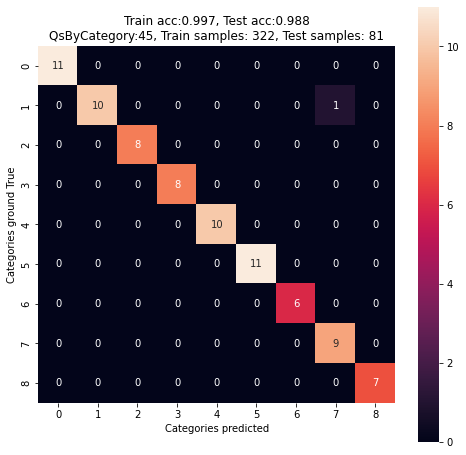

In [ ]:
# Asign categories to salient clusters
clusters = pd.read_pickle(CLUSTERING_DFS_FOLDER+"opc2:lemas:17:1_10grama:clustering_embeddings.pkl")

# Get the top question of each salient cluster, and assign the according categories
data = assignCategories(clusters, take_top_qs=45)

# Train
model = trainLogRegessionModel(data, save=1)

#### Test Results

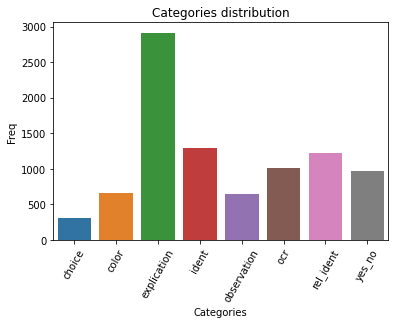

In [ ]:
# Predict all questions categories from cluster dataframe
predict = predictClustersCategories(model, clusters, n_samples=None)
plotCategoriesDist(predict)

###### Random samples

In [ ]:
printDf(predictClustersCategories(model, clusters, n_samples=30))

 category    | question                                                                                  |   labels
-------------+-------------------------------------------------------------------------------------------+----------
 ident       | what is this bottle of mobile?                                                            |        2
 ident       | what is this dvd?                                                                         |        2
 rel_ident   | what bill is that?                                                                        |       11
 rel_ident   | what is on this menu?                                                                     |       16
 observation | what did i just read on my pc?                                                            |        1
 explication | can you please describe this label to me thank you?                                       |        9
 explication | this stinks.                                            

###### Random samples by category name

In [ ]:
for name in predict.category.unique():
    printDf(predictClustersCategories(model, clusters, n_samples=20, category=name))
    print("")

 category   | question                                                                        |   labels
------------+---------------------------------------------------------------------------------+----------
 ocr        | what is the brand name of this detergent?                                       |        3
 ocr        | what is the dosage information for this supplement?                             |       16
 ocr        | i am staying in a high rise hotel and i am curious of the view from the window. |       15
 ocr        | what is the color for this keyboard?                                            |        3
 ocr        | what is the brand of this unit?                                                 |       16
 ocr        | what is the source of this image?                                               |       16
 ocr        | what kind of book is this and how thick is the book?                            |        8
 ocr        | what is the taste of these candies?     

### M1: Logistic Regression + embedding from bert-base-uncased model

#### Train

Train samples: 574, Test samples: 144
Train Accuracy: 1.000000
Test Accuracy: 0.951389


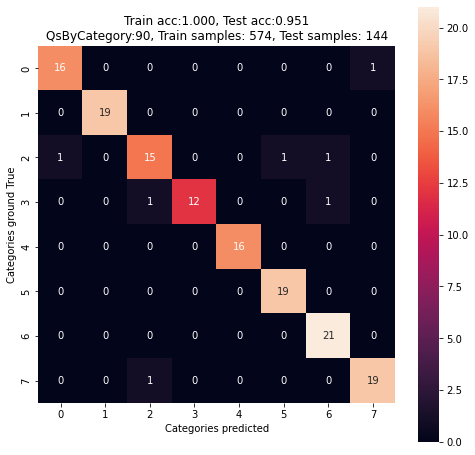

In [ ]:
# Asign categories to salient clusters
clusters = pd.read_pickle(CLUSTERING_DFS_FOLDER+"opc2:lemas:17:1_10grama:bert-base-uncased_embeddings.pkl")

# Get the top question of each salient cluster, and assign the according categories
data = assignCategories(clusters, take_top_qs=90)

# Train
model = trainLogRegessionModel(data,save=False)

# Save model
save_model = False
if save_model:
    saveClassifierModel(classifier_model=model, 
                        embedding_model=SentenceTransformer('bert-base-uncased'), 
                        filename="classifier_model:LRegression:bert-base-uncased:v2")

#### Test Results

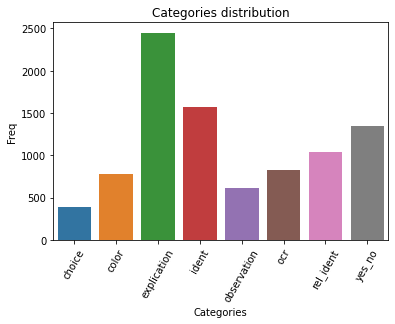

In [ ]:
# Predict all questions categories from cluster dataframe
predict = predictClustersCategories(model, clusters, n_samples=None)
plotCategoriesDist(predict)

###### Random samples

In [ ]:
printDf(predictClustersCategories(model, clusters, n_samples=30))

   labels | category    | question
----------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------
        0 | color       | what color is this product?
        3 | rel_ident   | what is the writing on this box.
        1 | observation | what does this dialog box say?
        5 | yes_no      | is this card readable now?
        7 | rel_ident   | what is in this jar according to the label shown?
        8 | ident       | what kind of water is this?
        0 | color       | what color has there?
        1 | observation | what does this windows xp error say?
       16 | ocr         | what is the frequency?
        7 | explication | screen showing.
        9 | explication | can you please read this menu to me.
       14 | rel_ident   | please tell me what is in this box
       16 | rel_ident   | what is in this can please?
       14 | rel_ident   | what is on the screen?

###### Random samples by category name

In [ ]:
for name in predict.category.unique():
    printDf(predictClustersCategories(model, clusters, n_samples=20, category=name))
    print("")

   labels | category   | question
----------+------------+-------------------------------------------------------------------------
        3 | ocr        | what is the redemption code of this card?
        3 | ocr        | what is the name of this please?
        3 | ocr        | what is the denominator of this bill?
        3 | ocr        | what is the thermostat setting for the air conditioning on this device?
        3 | ocr        | what is the picture on this map?
        3 | ocr        | what are the labels of the buttons in this row?
        3 | ocr        | what is the color of the cap of this bottle?
        3 | ocr        | what is the isbn for this book?
        3 | ocr        | what is the name of this audio book and the actual number of the disc?
       16 | ocr        | what is the name of the cd?
        3 | ocr        | what is the name of the flower?
        3 | ocr        | what is the temperature on the display set to?
       16 | ocr        | what is the temperatur

### M2: SVC + embedding from bert-base-uncased model

#### Train

Train samples: 510, Test samples: 128
Train Accuracy: 1.000000
Test Accuracy: 0.984375


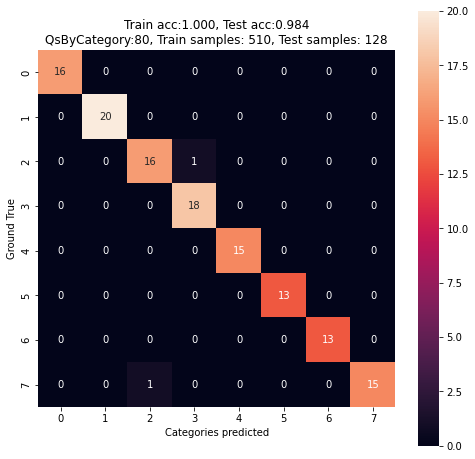

In [ ]:
# Asign categories to salient clusters
clusters = pd.read_pickle(CLUSTERING_DFS_FOLDER+"opc2:lemas:17:1_10grama:bert-base-uncased_embeddings.pkl")

# Get the top question of each salient cluster, and assign the according categories
data = assignCategories(clusters, take_top_qs=80)

# Train
model = trainSvcModel(data,save=False)

# Save model
save_model = False
if save_model:
    saveClassifierModel(classifier_model=model, 
                        embedding_model=SentenceTransformer('bert-base-uncased'), 
                        filename="classifier_model:Svm:bert-base-uncased:v2")

#### Test Results

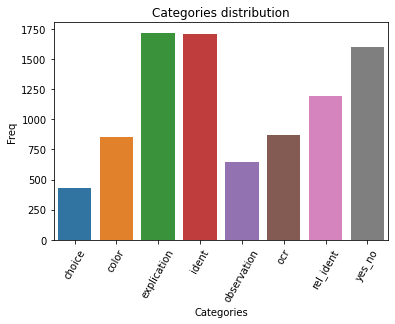

In [ ]:
# Predict all questions categories from cluster dataframe
predict = predictClustersCategories(model, clusters, n_samples=None)
plotCategoriesDist(predict)

###### Random samples

In [ ]:
printDf(predictClustersCategories(model, clusters, n_samples=30))

   labels | category    | question
----------+-------------+------------------------------------------------------------------------------------------------
       15 | explication | this is the display of the treadmill, can you tell me the distance off the top display please?
       15 | explication | how well did i capture the kitty in the picture?
        8 | ident       | what kind of jimmy deans breakfast sandwiches are these?
       16 | ocr         | what temperature is the oven set to?
        0 | color       | what color is the pillow?
        6 | ident       | what make of car is this?
        3 | ocr         | what is the label on this jar?
        4 | explication | can you tell which phone number this is if possible please?
        4 | explication | how many calories are in this bottle?
        0 | color       | what color is the blanket in the picture?
        9 | color       | please describe the colors in this pair of socks.
        4 | explication | what temperature dis

###### Random samples by category name

In [ ]:
for name in predict.category.unique():
    printDf(predictClustersCategories(model, clusters, n_samples=20, category=name))
    print("")

   labels | category   | question
----------+------------+-------------------------------------------------------------------------------------------
        3 | ocr        | what is the contents of this can please?
       16 | ocr        | what is the taste of the pack?
        3 | ocr        | what is the ounces on this box of tamales?
        3 | ocr        | what is the brand name on the bottle?
       16 | ocr        | what is the number on the back of this card?
        3 | ocr        | what is the oven temperatures setting?
        3 | ocr        | what is the name, brand name, and flavor of this?
        3 | ocr        | what is the temperature showing on the control
        3 | ocr        | what is the flavor of this cat food, please?
        3 | ocr        | what is the answer to the math problem?
       16 | ocr        | what is the figure you see on the shirt
        3 | ocr        | alright what is the expiration on this carton of milk?
        3 | ocr        | what are th

### M3: Logistic Regression + embedding from all-MiniLM-L6-v2 model

#### Train

Train samples: 574, Test samples: 144
Train Accuracy: 0.926829
Test Accuracy: 0.909722


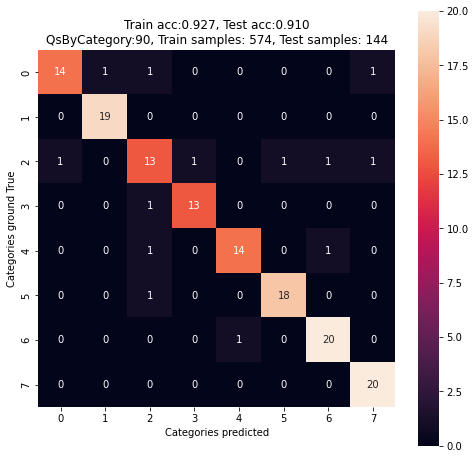

In [ ]:
# Asign categories to salient clusters
clusters = pd.read_pickle(CLUSTERING_DFS_FOLDER+"opc2:lemas:17:1_10grama:all-MiniLM-L6-v2_embeddings.pkl")

# Get the top question of each salient cluster, and assign the according categories
data = assignCategories(clusters, take_top_qs=90)

# Train
model = trainLogRegessionModel(data,save=False)

# Save model
save_model = False
if save_model:
    saveClassifierModel(classifier_model=model, 
                        embedding_model=SentenceTransformer('all-MiniLM-L6-v2'),
                        filename="classifier_model:LRegression:all-MiniLM-L6-v2:v2")

#### Test Results

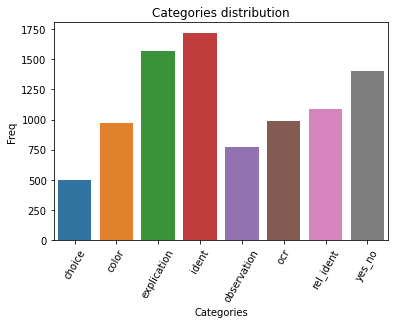

In [ ]:
# Predict all questions categories from cluster dataframe
predict = predictClustersCategories(model, clusters, n_samples=None)
plotCategoriesDist(predict)

###### Random samples

In [ ]:
printDf(predictClustersCategories(model, clusters, n_samples=30))

   labels | category    | question
----------+-------------+----------------------------------------------------------------------------------------------
        5 | choice      | is this white or black pepper?
        8 | ident       | what kind of shoe is this?
        8 | ident       | can you tell what kind of tea this is?
        1 | observation | what does this can say?
       15 | ocr         | can you tell me the name of the audio cd.
        2 | observation | last time, what is this say?
        6 | ident       | what type of can is this?
       15 | explication | what letters do i enter to win the prize?
        3 | observation | what is the captcha code on this image?
        4 | color       | if there is a phone in this picture can you tell what color it is?
        0 | color       | what color is this pair of pants?
       12 | yes_no      | is this corn as well?
        2 | rel_ident   | what is this item or items?
        8 | ident       | what kind of essential oil is 

###### Random samples by category name

In [ ]:
for name in predict.category.unique():
    printDf(predictClustersCategories(model, clusters, n_samples=20, category=name))
    print("")

   labels | category   | question
----------+------------+------------------------------------------------------------------------
        4 | ocr        | can you please tell me what the label says is in this tub.
       15 | ocr        | please tell me the name of this book?
       11 | ocr        | can you tell me what the thermostat temperature is set on, please?
        2 | ocr        | what is this product and how do you use it?
        7 | ocr        | what milligrams is this?
        3 | ocr        | what is the name or the title of this book?
        3 | ocr        | what is the name on this stocking?
        4 | ocr        | how many calories are in this bottle?
       16 | ocr        | what is the expiration date on this box?
        3 | ocr        | what are the directions for this meal?
        9 | ocr        | read the name of soup.
        9 | ocr        | how do you prepare this cake?
       10 | ocr        | who is this cd by?
        3 | ocr        | what is the tempe

### M4: SVC + embedding from all-MiniLM-L6-v2 model

#### Train

Train samples: 574, Test samples: 144
Train Accuracy: 0.973868
Test Accuracy: 0.923611
Input_name: 2


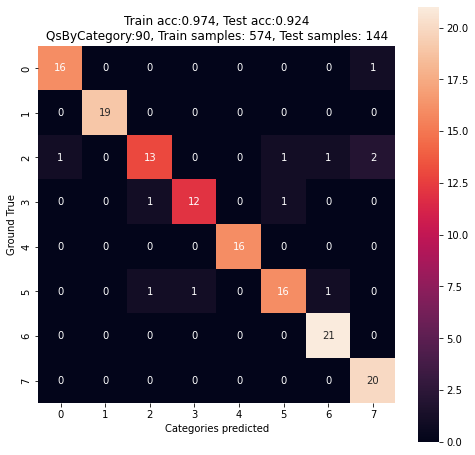

In [ ]:
# Asign categories to salient clusters
clusters = pd.read_pickle(CLUSTERING_DFS_FOLDER+"opc2:lemas:17:1_10grama:all-MiniLM-L6-v2_embeddings.pkl")

# Get the top question of each salient cluster, and assign the according categories
data = assignCategories(clusters, take_top_qs=90)

# Train
model = trainSvcModel(data, save=True)

# Save model
save_model = False
if save_model:
    saveClassifierModel(classifier_model=model, 
                        embedding_model=SentenceTransformer('all-MiniLM-L6-v2'), 
                        filename="classifier_model:Svm:all-MiniLM-L6-v2:v2")

#### Test Results

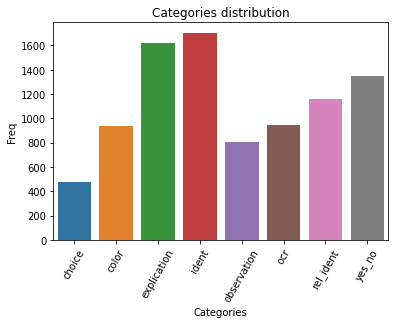

In [ ]:
# Predict all questions categories from cluster dataframe
predict = predictClustersCategories(model, clusters, n_samples=None)
plotCategoriesDist(predict)

###### Random samples

In [ ]:
printDf(predictClustersCategories(model, clusters, n_samples=30))

   labels | category    | question
----------+-------------+------------------------------------------------------------------------------------------------------------
       14 | rel_ident   | what is on television?
        7 | ocr         | can you tell me what this frozen dinner is and the conventional oven temperature and for how many minutes?
        1 | observation | what does this coupon say on it?
       11 | explication | can tell me what city and year this is?
        5 | choice      | is this yarn blue or purple?
        3 | color       | what is the color of the cap of this bottle?
        2 | rel_ident   | what is this showing?
        3 | ocr         | what are the cooking instructions on this package?
        2 | ident       | what is this photo?
        9 | explication | hi, can you tell me if this looks better?
        2 | explication | what is this computer model?
        0 | color       | what color laptop is that?
        5 | choice      | is this catalina regular 

###### Random samples by category name

In [ ]:
for name in predict.category.unique():
    printDf(predictClustersCategories(model, clusters, n_samples=20, category=name))
    print("")

   labels | category   | question
----------+------------+-------------------------------------------------------------------------------------------------------------
        3 | ocr        | what is the name of this can please?
        9 | ocr        | can you tell me the sodium content of this can of food?
        8 | ocr        | what kind of chex mix are those?
        7 | ocr        | can you tell me what this is and what the conventional number of degrees of the oven and number of minutes.
        3 | ocr        | is this beter what is the name of the cd?
       11 | ocr        | what brand of omelettes are these?
        9 | ocr        | what its name?
        2 | ocr        | what is this called?
       10 | ocr        | name this perfume.
        3 | ocr        | what is the name of this?
       16 | ocr        | what is the temperature setting on this thermostat?
        7 | ocr        | i am trying to find out the number of milligrams for this product.
       15 | ocr      